In [64]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [65]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [66]:
PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"
PATH_SAM="../Dati/12_APR/Run_chall_ChargeHistos_4_12_2024_10M.dat"
edge_N, bin_N = load_histo(PATH_MARTI)

channel = 10

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

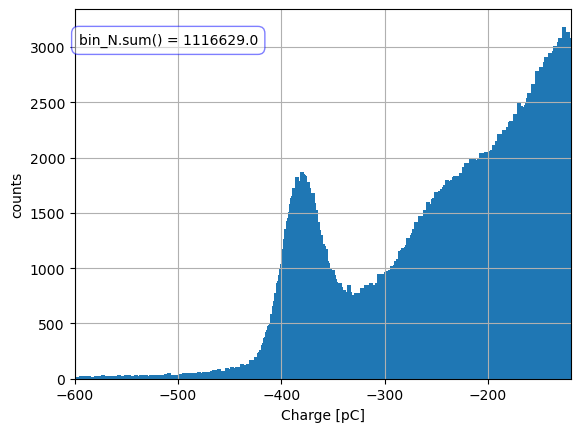

In [67]:
lim_list = [[-600, -165],  #ch0
            [-1, -1],      #ch1
            [-600, -175],  #ch2
            [-600, -145],  #ch3
            [-500, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [68]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [69]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [70]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

noise_params = noise_params[channel]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      5093     -inf      inf    49.47     True     None     None
e1_decay        -99.51     -inf      inf   0.6395     True     None     None
ratio            23.94     -inf      inf   0.7448    False e1_amplitude / s1_amplitude     None
s1_amplitude     212.7        0      inf    6.256     True     None     None
s1_center       -389.6     -inf      inf    1.579     True     None     None
s1_sigma         27.28        0      inf    1.256     True     None     None


In [71]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "ratio * s1_amplitude")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 70348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["e1_amplitude"].set(min=0)
    params["e1_decay"].set(value=-61)

    params["s1_amplitude"].set(value= 1534, min = 0)
    params["s1_center"].set(value=-270)
    params["s1_sigma"].set( value= 60)

    params["ratio"].set( value=4.89)

if channel ==2:

    params["g1_amplitude"].set(value = 425000 , min=0)   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 5000, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].value = 54057.2496

    params["s1_amplitude"].set(min = 0)

if channel ==3:

    params["g1_amplitude"].set(value = 425000, min=0 )   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 675, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].set( min=0)
    params["e1_decay"].set(value=-93)
    
    params["s1_amplitude"].set(value=927, min = 0)

    params["ratio"].set(value=7.71)

if channel == 4:
    
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -290, min = -340 , max = -260)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 2)
   
if channel == 5:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -300, min = -330 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=50, max=1000)
    params["s2_center"].set(value = -180, min=-250,max=-150 )
    params["s2_sigma"].set(value = 9, min=0 )

    params["s1_amplitude"].set(value=1000)

if channel ==6:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -280, min = -320 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["s1_amplitude"].set(value=1000)

if channel ==7:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -340, min = -380 , max = -300)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

 
if channel == 8:
    params["g1_center"].set(value = -379)
    params["g1_sigma"].set(value = 15)
    params["e1_amplitude"].set(value = 7000)
    params["s1_amplitude"].set(value = 327)
    params["s1_center"].set(value = -269)
    params["s1_sigma"].set(value = 6.2)
    params["s2_amplitude"].set(value = 862)
    params["s2_center"].set(value = -336)
    params["s2_sigma"].set(value = 29)


if channel == 9:
    params["g1_center"].value = -280
    params["g1_center"].min = -300
    #params["s2_amplitude"].max = 3000 #800
    #params["s2_center"].min = -150
   # params["s2_center"].max = -80
    #params["s2_amplitude"].min = 1000 

if channel == 10:
    params["g1_center"].value = -400
    params["g1_center"].max = -380
    params["s2_amplitude"].max= 1000
    params["s2_center"].min = -350
    params["s2_center"].max = -150
         




    

    

params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      5093        0      inf     None    False ratio * s1_amplitude     None
e1_decay        -99.51     -inf      inf     None     True     None     None
g1_amplitude         0        0      inf     None     True     None     None
g1_center         -400     -inf     -380     None     True     None     None
g1_fwhm          58.87     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height            0     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            25        0      inf     None     True     None     None
ratio            23.94     -inf      inf     None     True     None     None
s1_amplitude     212.7        0      inf     None     True     None     None
s1_center       -389.6     -inf      inf     None     True     None     None
s1_sigma         27.28        0      inf     None     True     None     None
s2_amplitude     

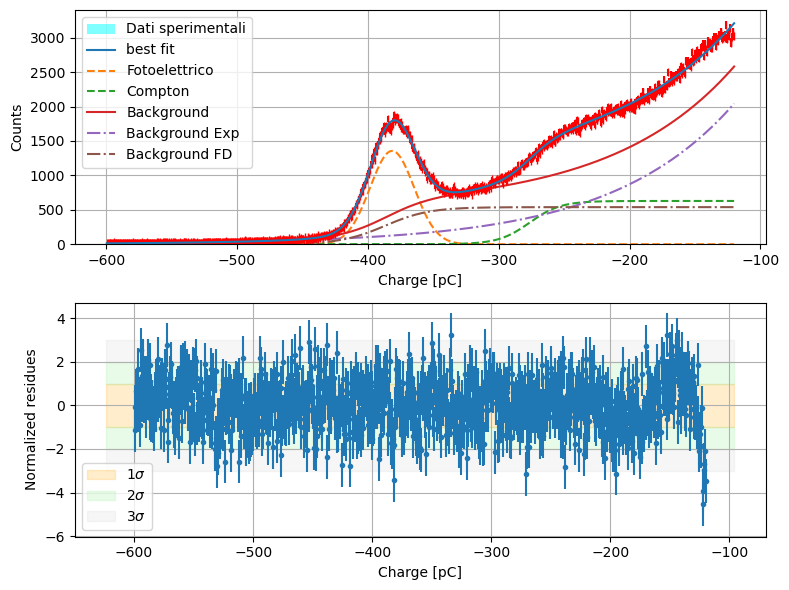

In [72]:
#FIT

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [73]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 439
    # data points      = 923
    # variables        = 11
    chi-square         = 1193.90494
    reduced chi-square = 1.30910630
    Akaike info crit   = 259.539073
    Bayesian info crit = 312.642995
    R-squared          = 0.99999854
[[Variables]]
    e1_amplitude:  7345.84174 +/- 84.1517963 (1.15%) == 'ratio * s1_amplitude'
    e1_decay:     -93.7708872 +/- 0.37387629 (0.40%) (init = -99.50631)
    s1_amplitude:  538.547453 +/- 14.4976767 (2.69%) (init = 212.7358)
    s1_center:    -386.671267 +/- 6.96424715 (1.80%) (init = -389.5904)
    s1_sigma:      16.8708919 +/- 1.96976667 (11.68%) (init = 27.2847)
    g1_amplitude:  57263.6640 +/- 2820.01774 (4.92%) (init = 0)
    g1_center:    -381.447211 +/- 0.13316963 (0.03%) (init = -40